Found 3001 images belonging to 8 classes.
Found 743 images belonging to 8 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
C:\Users\ghwns\AppData\Roaming\Python\Python310\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/25

Epoch 1: val_loss improved from inf to 2.05824, saving model to efficientnetb0_baseline.keras
47/47 - 96s - 2s/step - accuracy: 0.1370 - loss: 2.2543 - val_accuracy: 0.1723 - val_loss: 2.0582 - learning_rate: 1.0000e-04
Epoch 2/25

Epoch 2: val_loss improved from 2.05824 to 1.94367, saving model to efficientnetb0_baseline.keras
47/47 - 74s - 2s/step - accuracy: 0.1866 - loss: 2.1099 - val_accuracy: 0.2288 - val_loss: 1.9437 - learning_rate: 1.0000e-04
Epoch 3/25

Epoch 3: val_loss improved from 1.94367 to 1.85428, saving model to efficientnetb0_baseline.keras
47/47 - 73s - 2s/step - accuracy: 0.2153 - loss: 2.0361 - val_accuracy: 0.3136 - val_loss: 1.8543 - learning_rate: 1.0000e-04
Epoch 4/25

Epoch 4: val_loss improved from 1.85428 to 1.77022, saving model to efficientnetb0_baseline.keras
47/47 - 75s - 2s/step - accuracy: 0.2599 - loss: 1.9536 - val_accuracy: 0.3917 - val_loss: 1.7702 - learning_rate: 1.0000e-04
Epoch 5/25

Epoch 5: val_loss improved from 1.77022 to 1.711

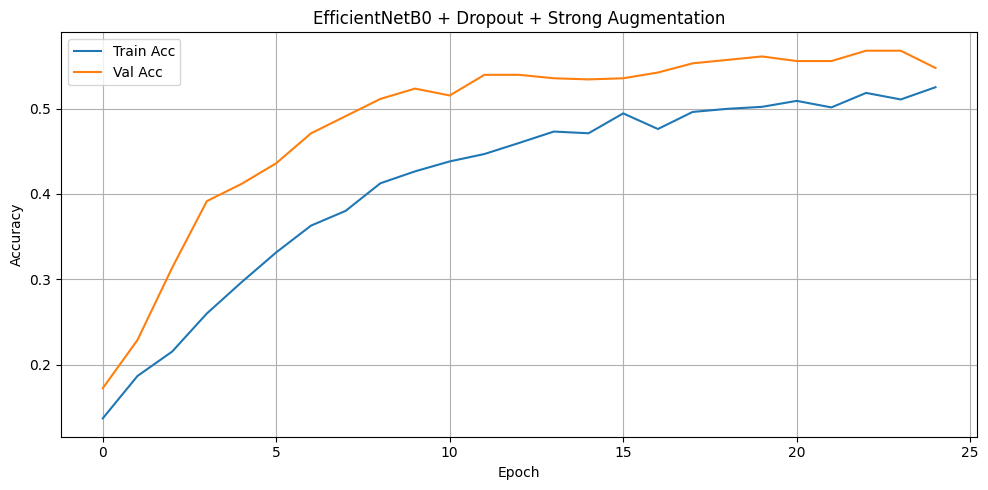

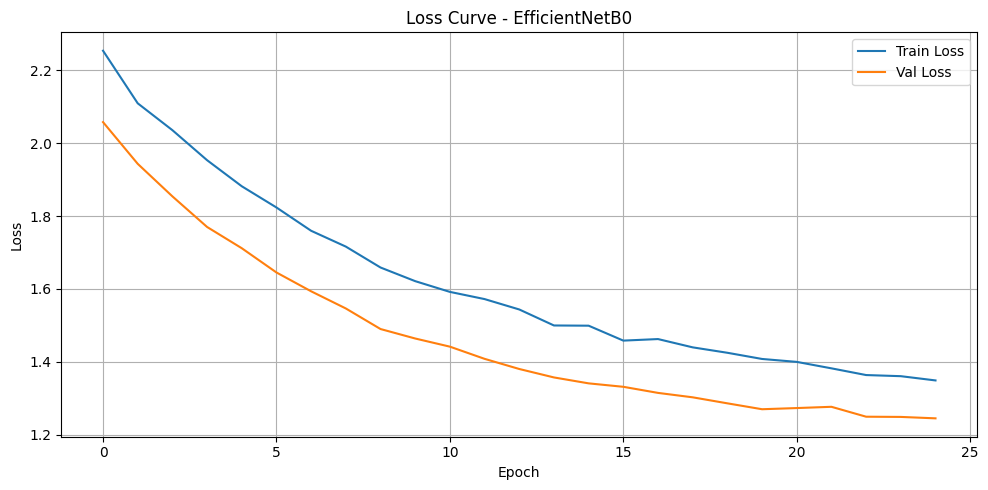

✅ Best val_acc: 0.5680 at epoch 23


In [5]:
# 📅 2025/06/06 - EfficientNetB0 Baseline + Dropout + Strong Augmentation

import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Dataset path
data_dir = r"C:\Users\ghwns\HJ_git\CV-Projects\real-time-daily-activity-recognizer\images"

# Data augmentation settings
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=10,
    horizontal_flip=True,
    validation_split=0.2
)

# Training data generator
train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(160, 160),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    subset='training',
    shuffle=True
)

# Validation data generator
val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(160, 160),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    subset='validation',
    shuffle=False
)

# Load EfficientNetB0 as feature extractor
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(160, 160, 3))
base_model.trainable = False  # Freeze base model for now

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
checkpoint_path = "efficientnetb0_baseline.keras"
checkpointer = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, verbose=1)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Train model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[checkpointer, lr_reducer, early_stopper],
    verbose=2
)

# Plot accuracy
acc_fig_path = r"C:\Users\ghwns\HJ_git\CV-Projects\real-time-daily-activity-recognizer\figures\exp_20250606_efficientnetb0_dropout.png"
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNetB0 + Dropout + Strong Augmentation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(acc_fig_path)
plt.show()

# Plot loss
loss_fig_path = r"C:\Users\ghwns\HJ_git\CV-Projects\real-time-daily-activity-recognizer\figures\exp_20250606_efficientnetb0_dropout_loss.png"
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve - EfficientNetB0')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(loss_fig_path)
plt.show()

# Print best validation accuracy
val_acc = history.history['val_accuracy']
best_epoch = np.argmax(val_acc) + 1
best_val = val_acc[best_epoch - 1]
print(f"✅ Best val_acc: {best_val:.4f} at epoch {best_epoch}")